In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lucem_illud as li
import incels

Reading the data scraped form Incels.is

In [27]:
bans_df = pd.read_json('data/scraped/bans.json')

In [28]:
bans_df

,title,label,link,author,time,messages
0,READ FIRST: How to appeal a ban.,NaN,/web/20181110000930/https://incels.is/threads/...,SergeantIncel,1516204285,"[{'username': 'SergeantIncel', 'user_title': '..."
1,Unsure of why I was perm'd,NaN,/web/20181110000930/https://incels.is/threads/...,Watac,1541698539,"[{'username': 'Watac', 'user_title': 'Banned',..."
2,Unban me ASAP,NaN,/web/20181110000930/https://incels.is/threads/...,FaceandHFD,1541676909,"[{'username': 'FaceandHFD', 'user_title': 'NoL..."
3,Unban Please,NaN,/web/20181110000930/https://incels.is/threads/...,Bose_2003,1541091605,"[{'username': 'Bose_2003', 'user_title': 'Bann..."
4,Requested a ban for looksmaxing,NaN,/web/20181110000930/https://incels.is/threads/...,Twisted,1541289377,"[{'username': 'Twisted', 'user_title': '19 yea..."
...,...,...,...,...,...,...
372,My apology to the moderators,NaN,/web/20181121030418/https://incels.is/threads/...,CHUTIYACEL,1517326032,"[{'username': 'CHUTIYACEL', 'user_title': 'Ban..."
373,Ban appeal,NaN,/web/20181121030418/https://incels.is/threads/...,Blackpill_Chad,1517197614,"[{'username': 'Blackpill_Chad', 'user_title': ..."
374,Let me try again.,NaN,/web/20181121030418/https://incels.is/threads/...,Grain_of_sin,1516935316,"[{'username': 'Grain_of_sin', 'user_title': 'B..."
375,unban me brahs,NaN,/web/20181121030418/https://incels.is/threads/...,iiiTeMpeR,1516880362,"[{'username': 'iiiTeMpeR', 'user_title': 'Admi..."


Doing some cleanup

In [55]:
datetime = pd.to_datetime(bans_df['time'], unit='s')
datetime

0     2018-01-17 15:51:25
1     2018-11-08 17:35:39
2     2018-11-08 11:35:09
3     2018-11-01 17:00:05
4     2018-11-03 23:56:17
              ...        
372   2018-01-30 15:27:12
373   2018-01-29 03:46:54
374   2018-01-26 02:55:16
375   2018-01-25 11:39:22
376   2018-01-18 01:22:14
Name: time, Length: 377, dtype: datetime64[ns]

Creating a function to deal with converting the posts into a dataframe with posts AND comments

In [228]:
def create_response_df(df, id, stop_words=[]):
    post_id = -1
    response_df = pd.DataFrame()
    for row in df.iterrows():
        post_id += 1
        comment_id = -1
        thread_title = row[1]['title']
        thread_author = row[1]['author']
        thread_time = row[1]['time']
        thread_tag = row[1]['label']
        thread = row[1]['messages']
        for message in thread:
            comment_id += 1
            response_df = response_df.append({'post_id': post_id, 'comment_id': comment_id, 'thread_title': thread_title, 'thread_tag': thread_tag, 'thread_author': thread_author, 'thread_time': thread_time, 
            'username': message['username'], 'user_label': message['user_title'], 'post_time': message['post_time'], 'raw_text': message['raw_text']}, ignore_index=True)
    response_df['thread_time'] = pd.to_datetime(response_df['thread_time'], unit='s')
    response_df['post_time'] = pd.to_datetime(response_df['post_time'], unit='s')
    response_df['post_id'] = response_df['post_id'].astype(int)
    response_df['comment_id'] = response_df['comment_id'].astype(int)
    response_df['tokens'] = response_df['raw_text'].apply(lambda x: li.word_tokenize(x))
    response_df['normal_tokens'] = response_df['tokens'].apply(lambda x: li.normalizeTokens(x, extra_stop=stop_words))
    response_df['normal_tokens_POS'] = response_df['normal_tokens'].apply(lambda x: li.spacy_pos(x))
    
    #create unique id by combining post_id_comment_id 
    response_df['id'] = id + response_df['post_id'].astype(str) + '_' + response_df['comment_id'].astype(str)
    response_df = response_df[['id', 'post_id', 'comment_id', 'thread_title', 'thread_tag', 'thread_author', 'thread_time', 'username', 'user_label', 'post_time', 'raw_text', 'tokens', 'normal_tokens', 'normal_tokens_POS']]
    return response_df

Some overly common words that I noticed in preliminary work

In [287]:
stops = ['click', 'expand', 'said', 'https', 'youtube', 'youtu', 'view', 'attachment', 'http', 'com', 'www']

In [213]:

ban_resp = create_response_df(bans_df, 'ban_', stop_words=stops)
feedback_resp = create_response_df(pd.read_json('data/scraped/feedback.json'), 'feedback_', stop_words=stops)
main_resp = create_response_df(pd.read_json('data/scraped/main.json'), 'main_', stop_words=stops)
offtopic_resp = create_response_df(pd.read_json('data/scraped/offtopic.json'), 'offtopic_', stop_words=stops)

C:\Users\Zacha\anaconda3\envs\testing\lib\site-packages\spacy\pipeline\lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


In [288]:
ban_resp['normal_tokens'] = ban_resp['tokens'].apply(lambda x: li.normalizeTokens(x, extra_stop=stops))
feedback_resp['normal_tokens'] = feedback_resp['tokens'].apply(lambda x: li.normalizeTokens(x, extra_stop=stops))
main_resp['normal_tokens'] = main_resp['tokens'].apply(lambda x: li.normalizeTokens(x, extra_stop=stops))
offtopic_resp['normal_tokens'] = offtopic_resp['tokens'].apply(lambda x: li.normalizeTokens(x, extra_stop=stops))

In [274]:
feedback_resp

,id,post_id,comment_id,thread_title,thread_tag,thread_author,thread_time,username,user_label,post_time,raw_text,tokens,normal_tokens,normal_tokens_POS
0,feedback_0_0,0,0,Ban Discussion Megathread,NaN,SergeantIncel,2018-07-01 16:24:29,SergeantIncel,Admincel,2018-07-01 16:24:29,This megathread is for the community to discus...,"[This, megathread, is, for, the, community, to...","[megathread, community, discuss, bans, general...","[(megathread, JJ), (community, NN), (discuss, ..."
1,feedback_0_1,0,1,Ban Discussion Megathread,NaN,SergeantIncel,2018-07-01 16:24:29,Evil Genius,Hiiiii,2018-07-01 16:29:53,This thread will be interesting haha.,"[This, thread, will, be, interesting, haha]","[thread, interesting, haha]","[(thread, NN), (interesting, JJ), (haha, NN)]"
2,feedback_0_2,0,2,Ban Discussion Megathread,NaN,SergeantIncel,2018-07-01 16:24:29,GreenBull,Banned,2018-07-01 16:37:12,"Free @Kointo, I can gladly give up on my own a...","[Free, @Kointo, I, can, gladly, give, up, on, ...","[free, @kointo, gladly, account, unbanned]","[(free, JJ), (@kointo, NNP), (gladly, RB), (ac..."
3,feedback_0_3,0,3,Ban Discussion Megathread,NaN,SergeantIncel,2018-07-01 16:24:29,Bagelcel,King Framecel,2018-07-01 16:39:56,IDK who this Kointo is cause i'm junecel but c...,"[IDK, who, this, Kointo, is, cause, i, 'm, jun...","[idk, kointo, cause, m, junecel, considering, ...","[(idk, NNP), (kointo, NNP), (cause, NNP), (m, ..."
4,feedback_0_4,0,4,Ban Discussion Megathread,NaN,SergeantIncel,2018-07-01 16:24:29,SergeantIncel,Admincel,2018-07-01 16:48:22,"GreenBull said:\n\n\n\nFree @Kointo, I can gla...","[GreenBull, said, Free, @Kointo, I, can, gladl...","[greenbull, free, @kointo, gladly, account, un...","[(greenbull, NN), (said, VBD), (free, JJ), (@k..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35257,feedback_601_105,601,105,Rule change proposal: ban anyone who admits to...,NaN,itsOVER,2018-04-09 17:31:42,PM_ME_STRIPPERS,here to save m'lady from da niceguys!!!! xDDDDDD,2018-04-10 17:06:34,cope,[cope],[cope],"[(cope, VB)]"
35258,feedback_601_106,601,106,Rule change proposal: ban anyone who admits to...,NaN,itsOVER,2018-04-09 17:31:42,Darthmat,Captain,2018-04-10 17:40:24,ITS OVER!!! ERR!!! OVA!!!,"[ITS, OVER, ERR, OVA]","[err, ova]","[(err, NNP), (ova, NNP)]"
35259,feedback_601_107,601,107,Rule change proposal: ban anyone who admits to...,NaN,itsOVER,2018-04-09 17:31:42,Chris_Jones,An outcast among outcasts,2018-04-13 11:04:34,So incels aren't allowed to have friends? Fuck...,"[So, incels, are, n't, allowed, to, have, frie...","[incels, allowed, friends, fuck]","[(incels, NNS), (allowed, VBD), (friends, NNS)..."
35260,feedback_601_108,601,108,Rule change proposal: ban anyone who admits to...,NaN,itsOVER,2018-04-09 17:31:42,BlkPillPres,Fakecel Slayer,2018-04-14 01:50:05,itsOVER said:\n\n\n\nTI'm fucking SICK of bein...,"[itsOVER, said, TI'm, fucking, SICK, of, being...","[itsover, ti'm, fucking, sick, lifemogged, for...","[(itsover, NNP), (said, VBD), (ti'm, CD), (fuc..."


In [286]:
offtopic_resp.to_csv('data/offtopic_resp.csv', index=False)
feedback_resp.to_csv('data/feedback_resp.csv', index=False)
main_resp.to_csv('data/main_resp.csv', index=False)
ban_resp.to_csv('data/ban_resp.csv', index=False)

In [225]:
all_resp = pd.concat([ban_resp, feedback_resp, main_resp, offtopic_resp])

Creating lists of ALL tokens to use with NLTK

In [237]:
ban_tokens = ban_resp['tokens'].sum()
feedback_tokens = feedback_resp['tokens'].sum()
main_tokens = main_resp['tokens'].sum()
offtopic_tokens = offtopic_resp['tokens'].sum()

Using nltk I count the slang terms' usage and also calculate their frequency as percent of total words

In [239]:
import nltk
banText = nltk.Text(ban_tokens)
feedbackText = nltk.Text(feedback_tokens)
mainText = nltk.Text(main_tokens)
offtopicText = nltk.Text(offtopic_tokens)

In [241]:
count_df = pd.DataFrame(columns=['term', 'ban_count', 'feedback_count', 'main_count', 'offtopic_count'])
for term in incels.get_slang(3):
    count_df = count_df.append({'term': term, 'ban_count': banText.count(term), 'feedback_count': feedbackText.count(term), 'main_count': mainText.count(term), 'offtopic_count': offtopicText.count(term)}, ignore_index=True)

In [294]:
percent_df = pd.DataFrame(columns=['term', 'ban_percent', 'feedback_percent', 'main_percent', 'offtopic_percent'])
for term in incels.get_slang(3):
    percent_df = percent_df.append({'term': term, 'ban_percent': banText.count(term)/len(ban_tokens), 'feedback_percent': feedbackText.count(term)/len(feedback_tokens), 'main_percent': mainText.count(term)/len(main_tokens), 'offtopic_percent': offtopicText.count(term)/len(offtopic_tokens)}, ignore_index=True)

In [296]:
#convert percent_df values to percentages
percent_df['ban_percent'] = percent_df['ban_percent']*100

In [300]:
percent_df.sort_values(by='main_percent', ascending=False).head(10)

,term,ban_percent,feedback_percent,main_percent,offtopic_percent
67,incel,0.183045,0.001720,0.001298,0.000838
49,foid,0.005085,0.000638,0.001099,0.000345
35,chad,0.013559,0.000302,0.000665,0.000358
41,cuck,0.013559,0.000293,0.000492,0.000409
39,cope,0.028813,0.000305,0.000397,0.000577
139,normie,0.016949,0.000295,0.000314,0.000239
2,blackpill,0.027118,0.000312,0.000275,0.000127
87,inceldom,0.028813,0.000218,0.000257,0.000093
199,whore,0.000000,0.000085,0.000202,0.000052
120,manlet,0.003390,0.000096,0.000199,0.000255


In [298]:
percent_df[percent_df['term'] == 'foid']

,term,ban_percent,feedback_percent,main_percent,offtopic_percent
49,foid,0.005085,0.000638,0.001099,0.000345


In [299]:
percent_df[percent_df['term'] == 'incel']

,term,ban_percent,feedback_percent,main_percent,offtopic_percent
67,incel,0.183045,0.00172,0.001298,0.000838


In [242]:
count_df['total'] = count_df['ban_count'] + count_df['feedback_count'] + count_df['main_count'] + count_df['offtopic_count']

Interesting top terms here, I'd imagine it would be odd to see incel as the number one slang term, but as I have been researching Incels for a while, it actually makes a lot of sense.

Some brief explanations of terms. I am sorry for making you read these.
- Foid = Female + Android, one of most common way for Incels to refer to women
- Chad = stronger, sexually/romantically successful men <---- Interestingly enough has spread outside of the Incel sphere although in more of a joking way, whereas Incels use it seriously
- Cope = things which people "delude" themselves into ignoring the "reality" of the incels
- Fakecel = Fake incel
- Cuck = shortened cuckold, someone who is cheated on, also used to refer to weak men
- Normie = Normals, men who haven't "woken up" to the Incel truths
- Blackpill = Matrix reference, refering to the knowledge which "wakes you up to the Incel truths"
- JFL = Just Fucking Lol, term used to highlight things that make incels just fucking laugh
- Inceldom = The state of being an Incel

In [246]:
count_df[count_df['total'] > 0].sort_values(by='total', ascending=False).head(10)

,term,ban_count,feedback_count,main_count,offtopic_count,total
67,incel,108,2059,1276,513,3956
49,foid,3,764,1080,211,2058
35,chad,8,362,654,219,1243
39,cope,17,365,390,353,1125
81,fakecel,7,968,94,42,1111
41,cuck,8,351,484,250,1093
139,normie,10,353,309,146,818
2,blackpill,16,374,270,78,738
94,jfl,2,462,88,90,642
87,inceldom,17,261,253,57,588


In [290]:
main_counts = count_df[['term', 'main_count']]

More term explanations, once again apologies to you for making you read these:
- Manlet = Weak man
- Rope = Not just the noun but a reference suicide, to commit rope, or to rope oneself
- Beta = subservient man
- mog = To establish oneself as more valuable than another as a form of domination or humilation, often referring to Chads mogging incels
- looksmatch = equivalent looks in the opposite sex
- suifuel = shortening of Suicide Fuel
- betabux = Refers to idea that women sleep with less attractive but wealthy men


In [292]:
main_counts.sort_values(by='main_count', ascending=False).head(20)

,term,main_count
67,incel,1276
49,foid,1080
35,chad,654
41,cuck,484
39,cope,390
139,normie,309
2,blackpill,270
87,inceldom,253
199,whore,199
120,manlet,196


Not much revealed when looking at the slang terms

In [278]:
mainText.common_contexts(['foid'])

a_and a_that a_in a_is some_that a_at a_'s a_with some_on cute_and
a_to a_i some_with this_is a_on this_and attractive_for a_from
some_waiting a_as


Oh, this is a username?

In [289]:
mainText.common_contexts(['springheeledjack'])

expand_said system_said feces_said suifuel_said example_said
looksmaxxing_said internet_said me_said man_said genes_said about_said
boyo_said here_said chad_said shotgun_said better_said right_said
marriage_said chance_said age_said


In [253]:
top_slang = count_df[count_df['total'] > 0].sort_values(by='total', ascending=False).head(10).values
#convert to list
top_slang = [x[0] for x in top_slang]

In [254]:
top_slang

['incel',
 'foid',
 'chad',
 'cope',
 'fakecel',
 'cuck',
 'normie',
 'blackpill',
 'jfl',
 'inceldom']

In [159]:
%matplotlib inline

Creating some lexical dispersion plots for analysis

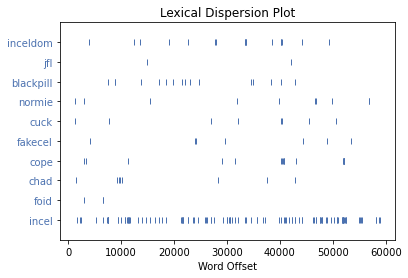

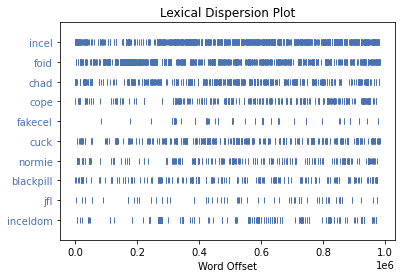

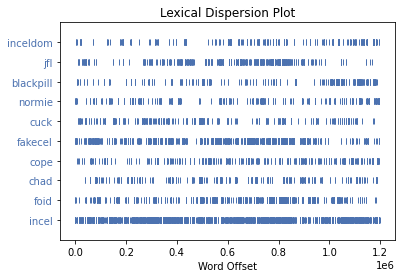

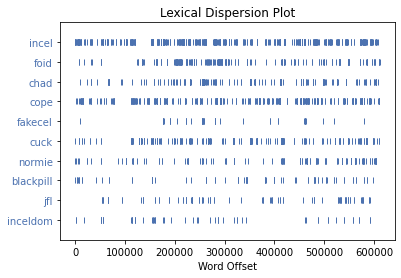

In [256]:
sns.reset_orig()
banText.dispersion_plot(top_slang)
mainText.dispersion_plot(top_slang)
feedbackText.dispersion_plot(top_slang)
offtopicText.dispersion_plot(top_slang)
sns.set()
plt.show()

In [257]:
banDist = nltk.ConditionalFreqDist((len(w), w) for w in banText)
feedbackDist = nltk.ConditionalFreqDist((len(w), w) for w in feedbackText)
mainDist = nltk.ConditionalFreqDist((len(w), w) for w in mainText)
offtopicDist = nltk.ConditionalFreqDist((len(w), w) for w in offtopicText)

This highlights some problems with the tokens as these words don't really seem relevant to any discussions at all

In [267]:
banProbDist = nltk.ConditionalProbDist(banDist, nltk.MLEProbDist)
feedbackProbDist = nltk.ConditionalProbDist(feedbackDist, nltk.MLEProbDist)
mainProbDist = nltk.ConditionalProbDist(mainDist, nltk.MLEProbDist)
offtopicProbDist = nltk.ConditionalProbDist(offtopicDist, nltk.MLEProbDist)

x = 5
print(banProbDist[x].max())
print(banProbDist[x].prob(banProbDist[x].max()))
print(feedbackProbDist[x].max())
print(feedbackProbDist[x].prob(feedbackProbDist[x].max()))
print(mainProbDist[x].max())
print(mainProbDist[x].prob(mainProbDist[x].max()))
print(offtopicProbDist[x].max())
print(offtopicProbDist[x].prob(offtopicProbDist[x].max()))

about
0.03682819383259912
Click
0.21235859237625182
Click
0.09518138594924261
Click
0.1391092910161249


Looking at some part of speech tagging

In [193]:
# banFDist_WordToPOS = nltk.ConditionalFreqDist(ban_resp['normalized_tokens_POS'].sum())
banFDist_WordToPOS = nltk.ConditionalFreqDist((p, w) for w, p in ban_resp['normalized_tokens_POS'].sum())

"unfair" is a very interesting word to appear in my opinion.

In [197]:
banFDist_WordToPOS['JJ']

FreqDist({'good': 55, 'sorry': 53, 'unfair': 41, 'ugly': 40, 'real': 38, 'new': 38, 'bad': 37, 'female': 34, 'long': 33, 'permanent': 31, ...})

In [279]:
import wordcloud
ban_wc = wordcloud.WordCloud(background_color='white', max_words=500, width=1000, height=1000, mode='RGBA', scale=0.5).generate(' '.join(ban_resp['normal_tokens'].sum()))
feedback_wc = wordcloud.WordCloud(background_color='white', max_words=500, width=1000, height=1000, mode='RGBA', scale=0.5).generate(' '.join(feedback_resp['normal_tokens'].sum()))
main_wc = wordcloud.WordCloud(background_color='white', max_words=500, width=1000, height=1000, mode='RGBA', scale=0.5).generate(' '.join(main_resp['normal_tokens'].sum()))
offtopic_wc = wordcloud.WordCloud(background_color='white', max_words=500, width=1000, height=1000, mode='RGBA', scale=0.5).generate(' '.join(offtopic_resp['normal_tokens'].sum()))

Word clouds. Makes sense that banned has such a presence on the Ban subforum, but and meta-words like "thread" appear on the Feedback/Meta forum. Offtopic shows some clear pollution with things like https and youtube and such appearing frequently. And the cloud for the main is remarkably clear about what they are discussing.

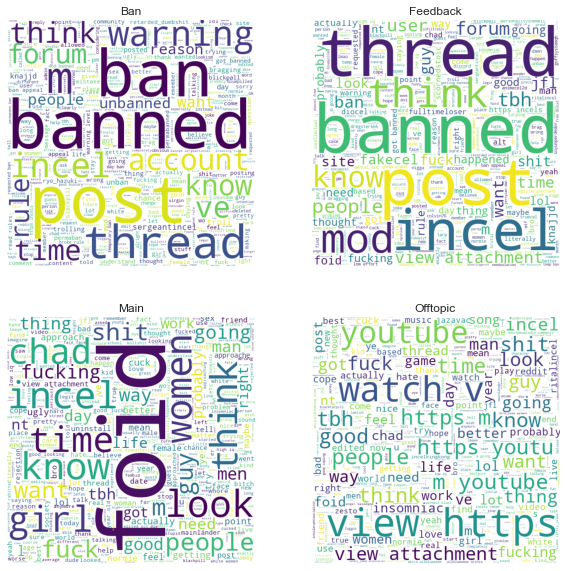

In [283]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
fig.set_facecolor('white')
axs[0, 0].imshow(ban_wc)
axs[0, 0].axis('off')
axs[0, 0].set_title('Ban')
axs[0, 1].imshow(feedback_wc)
axs[0, 1].axis('off')
axs[0, 1].set_title('Feedback')
axs[1, 0].imshow(main_wc)
axs[1, 0].axis('off')
axs[1, 0].set_title('Main')
axs[1, 1].imshow(offtopic_wc)
axs[1, 1].axis('off')
axs[1, 1].set_title('Offtopic')
plt.show()